# Wind analysis

In [2]:
import xarray as xr
import numpy as np
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt, colors
from windrose import WindroseAxes
from cmocean import cm as cmo
from tqdm.notebook import tqdm
from salishsea_tools import wind_tools, places, viz_tools

%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 12

### Functions and definitions

Define functions for loading HRDPS and plotting wind time series.

In [4]:
def load_HRDPS(station, timerange):
    """Load HRDPS time series at STATION over TRANGE
    """

    # Read HRDPS from erddap
    j, i = places.PLACES[station]['HRDPS grid ji']
    u, v = [HRDPS.sel(time=slice(*timerange))[key][:, j, i].values for key in ['u_wind', 'v_wind']]

    # Calculate wind speed
    wspd = np.sqrt(u**2 + v**2)

    # Calculate wind direction
    wdir = 180 * np.arctan2(v, u) / np.pi
    wdir[wdir < 0] = wdir[wdir < 0] + 360

    # Format time to datetime.datetime
    time = HRDPS.sel(time=slice(*timerange)).time.values.astype('datetime64[s]').astype(datetime)
    
    return wspd, wdir, time

In [5]:
# NetCDF objects from erddap
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02')

# Station names (in order along thalweg from N)
station_names = ['Sentry Shoal', 'Sisters Islet', 'Halibut Bank', 'Sandheads']

# Initialize stations dict
stations = {}
for name in station_names:
    stations[name] = {'ji': []}
    for key in ['obs', 'HRDPS']:
        stations[name][key] = {'wspd': np.empty(0), 'wdir': np.empty(0), 'time': np.empty(0)}

### Read data

5 years $\times$ 4 stations = approximately 15 minutes on salish

In [6]:
# Define concatenation function
def append_variables(data, variables):
    for key, var in zip(['wspd', 'wdir', 'time'], variables):
        data[key] = np.hstack((data[key], var))

# Loop through years
for y in tqdm(range(2015, 2020)):
    
    # Loop through stations
    for station in station_names:
        
        # Read HRDPS from erddap (whole year)
        wspd, wdir, time = load_HRDPS(station, [datetime(y, 1, 1), datetime(y, 12, 31, 23)])
        append_variables(stations[station]['HRDPS'], [wspd, wdir, time])
        
        # Read DFO data (whole year)
        if station in ['Halibut Bank', 'Sentry Shoal']:
            wspd, wdir, time = wind_tools.read_DFO_buoy(station, y)
            append_variables(stations[station]['obs'], [wspd, wdir, time])
        
        # Read EC data (month by month)
        else:
            for m in range(1, 13):
                trange = [datetime(y, m, d).strftime('%d-%b-%Y') for d in [1, monthrange(y, m)[1]]]
                wspd, wdir, _, time, _, _ = wind_tools.get_EC_observations(station, *trange)
                append_variables(stations[station]['obs'], [wspd, wdir, time])

In [11]:
months = [date.month for date in stations['Sandheads']['obs']['time']]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


### Plot windroses

In order along the thalweg from N

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


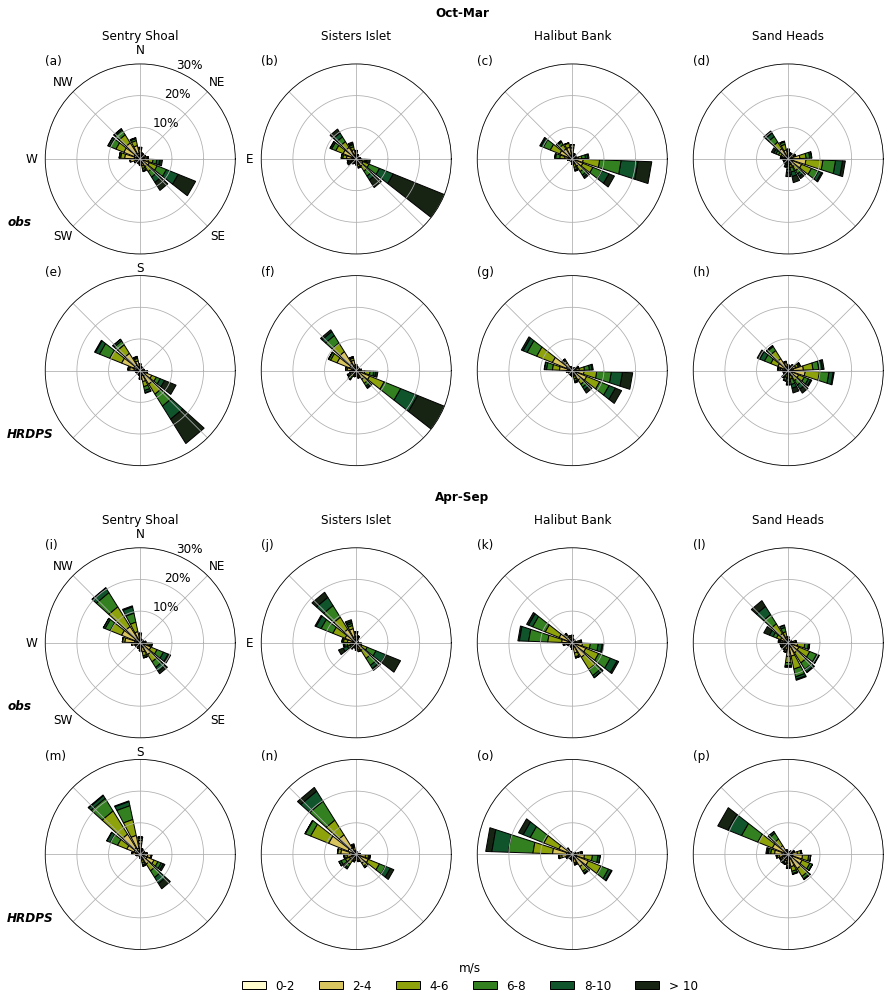

In [56]:
# Make figure
fig = plt.figure(figsize=(12, 14))

# Loop through stations and records
n = 0
for season, ypos in zip(['Oct-Mar', 'Apr-Sep'], [0.5, 0.02]):
    for record, yshift in zip(['obs', 'HRDPS'], [0.21, 0]):
        for station, xpos in zip(station_names, [0, 0.25, 0.5, 0.75]):

            # Plot wind data
            months = np.array([date.month for date in stations[station][record]['time']])
            tindex = (months > 3) & (months < 10)
            if season == 'Oct-Mar': tindex = ~tindex
            angle = 360 - stations[station][record]['wdir'][tindex] - 90
            angle[angle < 0] = angle[angle < 0] + 360

            # Make windrose object
            ax = WindroseAxes.from_ax(fig=fig)
            ax.set_position([xpos, ypos+yshift, 0.22, 0.24])
            ax.bar(
                angle, stations[station][record]['wspd'][tindex], bins=range(0, 11, 2),
                nsector=18, normed=True, opening=0.8, edgecolor='k', cmap=cmo.speed,
            )

            # Manually get legend handles (since WindroseAxes.bar returns None)
            handles = ax.get_children()[:6]

            # Formatting axis
            ax.set_ylim([0, 30])
            ax.yaxis.set_ticks([10, 20, 30])
            ax.yaxis.set_ticklabels('')
            ax.xaxis.set_ticklabels('')
            ax.text(0, 1, f'({chr(97+n)})', transform=ax.transAxes)
            if record == 'obs':
                title = 'Sand Heads' if station == 'Sandheads' else station
                ax.set_title(title, fontsize=12, y=1.1)
                if station == 'Sentry Shoal':
                    ax.xaxis.set_ticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
                    ax.yaxis.set_ticklabels([f'{tick}%' for tick in [10, 20, 30]])
                    ax.text(2.05, 1.25, season, transform=ax.transAxes, fontdict={'weight': 'bold'})
            if station == 'Sentry Shoal':
                ax.text(-0.2, 0.15, record, transform=ax.transAxes, fontdict={'style': 'italic', 'weight': 'bold'})
            n += 1

# Add legend
labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '> 10']
fig.legend(frameon=False, handles=handles, labels=labels, bbox_to_anchor=(0.82, 0.05), ncol=6, title='m/s')

fig.savefig('/home/bmoorema/Desktop/windroses.pdf', bbox_inches='tight')